In [45]:
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import tensorflow as tf
import torchvision
import torch
import pandas as pd
from torchsummary import summary
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score

from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable

# IMPORTING FUNCTIONS

In [2]:
from CNN_PGD import *

# IMPORTING DATA

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
)

testing_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

In [4]:
BATCH_SIZE = 100

data_loaders = {
    'train' : DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
    'test'  : DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=1),
}

# CNN MODEL

In [5]:
example_model = CNN()

summary(example_model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             208
              ReLU-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           3,216
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Linear-7                  [-1, 150]         117,750
              ReLU-8                  [-1, 150]               0
            Linear-9                  [-1, 150]          22,650
             ReLU-10                  [-1, 150]               0
           Linear-11                   [-1, 10]           1,510
Total params: 145,334
Trainable params: 145,334
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

# PARAMETERS

In [10]:
# CNN Training Params
EPOCHS = 10
LEARNING_RATE = 0.0005

# Testing
epses = [0, 0.1, 0.2, 0.3, 0.45]
TESTING_ITERATIONS = 40
TESTING_ALPHA = 0.01

# BASELINE

In [11]:
# TRAINING

classifier_baseline = CNN()
optimizer_baseline = optim.Adam(classifier_baseline.parameters(), lr = LEARNING_RATE)

(train_loss_baseline, train_accuracy_baseline) = train(cnn_model = classifier_baseline, 
                                                       data_load = data_loaders, 
                                                       optim = optimizer_baseline,
                                                       EPOCHS = EPOCHS)

Epoch [1/10], Progress [200/600], Loss: 0.2869
Epoch [1/10], Progress [400/600], Loss: 0.1357
Epoch [1/10], Progress [600/600], Loss: 0.1074
Epoch [2/10], Progress [200/600], Loss: 0.0887
Epoch [2/10], Progress [400/600], Loss: 0.1993
Epoch [2/10], Progress [600/600], Loss: 0.0937
Epoch [3/10], Progress [200/600], Loss: 0.0271
Epoch [3/10], Progress [400/600], Loss: 0.1347
Epoch [3/10], Progress [600/600], Loss: 0.0578
Epoch [4/10], Progress [200/600], Loss: 0.0882
Epoch [4/10], Progress [400/600], Loss: 0.0518
Epoch [4/10], Progress [600/600], Loss: 0.0691
Epoch [5/10], Progress [200/600], Loss: 0.0792
Epoch [5/10], Progress [400/600], Loss: 0.0316
Epoch [5/10], Progress [600/600], Loss: 0.0127
Epoch [6/10], Progress [200/600], Loss: 0.0094
Epoch [6/10], Progress [400/600], Loss: 0.0132
Epoch [6/10], Progress [600/600], Loss: 0.0353
Epoch [7/10], Progress [200/600], Loss: 0.0243
Epoch [7/10], Progress [400/600], Loss: 0.0389
Epoch [7/10], Progress [600/600], Loss: 0.0169
Epoch [8/10],

In [15]:
def targeted_pgd_attack(cnn_model, images, true_labels, eps, alpha, iterations, details=False):
    
    original_images = images.data
    
    for j in range(iterations):

        images.requires_grad = True
        (pred_label, _) = cnn_model(images)
        
        loss = LOSS_FUNCTION(pred_label, true_labels)
        loss.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-eps, max=eps)
        images = torch.clamp(original_images + eta, min=0, max=1).detach_()
        
    if details: print("____________________________________________ BEFORE PERTURBATION")
    if details: displayImage(original_images, 0)
    if details: print("TRUE LABEL:" + str(true_labels[0]))
        
    targeted_label, _ = cnn_model(images)
    
    if details: print("____________________________________________ AFTER PERTURBATION (TARGETTED)")
    if details: displayImage(images, 0)
    if details: print("CNN RESULT:" + str(targeted_label[0]))
    
    # DO NOT ALLOW TO CHOOSE TRUE LABEL
    targeted_label = [elem.detach().numpy() for elem in targeted_label]
    targeted_label = [removeTrueLabelFromTensor(targeted_label[i], true_labels[i]) for i in range(len(targeted_label))]
    targeted_label = torch.Tensor(np.array(targeted_label))
    targeted_label = torch.max(targeted_label, 1)[1].data.squeeze()
    
    if details: print("AKA: "+str(targeted_label[0]))
            
    return (loss, images, targeted_label)


In [ ]:
# TESTING

baseline_test = []
baseline_targeted = []
baseline_untargeted = []

for test_eps in epses:
    
    print("_____________________________________________ EPS:"+str(test_eps))
    
    print("___________ UNTARGETED:")

    (testing_acc, untargeted_acc) = pgd_test(cnn_model = classifier_baseline, 
                                                          data_load = data_loaders, 
                                                          pgd_function = untargeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    print("___________ TARGETED:")
    
    (_, targeted_acc) = pgd_test(cnn_model = classifier_baseline, 
                                                          data_load = data_loaders, 
                                                          pgd_function = targeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    baseline_test.append(testing_acc)
    baseline_untargeted.append(untargeted_acc)
    baseline_targeted.append(targeted_acc)

In [18]:
# SAVE DATA TO EXCEL

data = {}

for i, (test, untarget, target) in enumerate(zip(baseline_test, baseline_untargeted, baseline_targeted)):
    data['Testing_eps'+str(epses[i])] = [test, untarget, target]
    
df_baseline = pd.DataFrame(data, index=['Original_Test', 'Untargetted', 'Targetted'])
df_baseline = df_baseline.transpose()
df_baseline.to_csv("output\Classifier_Baseline_Test.csv")

data = {}

for i, (loss, acc) in enumerate(zip(train_loss_baseline, train_accuracy_baseline)):
    data['Training_epoch'+str(i)] = [loss, acc]

df_baseline = pd.DataFrame(data, index=['Training_Loss', 'Training_Accuracy'])
df_baseline = df_baseline.transpose()
df_baseline.to_csv("output\Classifier_Baseline_Train.csv")

# FIRST CLASSIFIER

In [25]:
# PARAMETERS (for PGD)

eps = 0.3
alpha = 0.02
iterations = 20

In [26]:
classifier_one = CNN()
optimizer_one = optim.Adam(classifier_one.parameters(), lr = LEARNING_RATE)  

In [27]:
# TRAINING

(one_orginal_images, one_pgd_images, one_pgd_labels, 
 one_training_loss, one_training_accuracy, 
 one_adv_training_loss, one_adv_training_accuracy) = pgd_train(cnn_model = classifier_one, 
                                                               data_load = data_loaders, 
                                                               optim = optimizer_one, 
                                                               pgd_function = untargeted_pgd_attack, 
                                                               EPOCHS = EPOCHS, 
                                                               eps = eps, 
                                                               alpha = alpha,
                                                               iterations = iterations)

Epoch [1/10], Progress [200/600], Loss: 2.3095
Epoch [1/10], Progress [400/600], Loss: 2.1268
Epoch [1/10], Progress [600/600], Loss: 1.4822
Epoch [2/10], Progress [200/600], Loss: 1.4099
Epoch [2/10], Progress [400/600], Loss: 1.1119
Epoch [2/10], Progress [600/600], Loss: 1.2881
Epoch [3/10], Progress [200/600], Loss: 0.7786
Epoch [3/10], Progress [400/600], Loss: 0.8214
Epoch [3/10], Progress [600/600], Loss: 0.7664
Epoch [4/10], Progress [200/600], Loss: 0.7450
Epoch [4/10], Progress [400/600], Loss: 0.7474
Epoch [4/10], Progress [600/600], Loss: 1.0180
Epoch [5/10], Progress [200/600], Loss: 0.7492
Epoch [5/10], Progress [400/600], Loss: 0.5517
Epoch [5/10], Progress [600/600], Loss: 0.8863
Epoch [6/10], Progress [200/600], Loss: 0.7863
Epoch [6/10], Progress [400/600], Loss: 0.6018
Epoch [6/10], Progress [600/600], Loss: 0.7035
Epoch [7/10], Progress [200/600], Loss: 0.4814
Epoch [7/10], Progress [400/600], Loss: 0.4381
Epoch [7/10], Progress [600/600], Loss: 0.4447
Epoch [8/10],

In [ ]:
# TESTING

one_test = []
one_targeted = []
one_untargeted = []

for test_eps in epses:
    
    print("_____________________________________________ EPS:"+str(test_eps))
    
    print("___________ UNTARGETED:")

    (testing_acc, untargeted_acc) = pgd_test(cnn_model = classifier_one, 
                                                          data_load = data_loaders, 
                                                          pgd_function = untargeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    print("___________ TARGETED:")
    
    (_, targeted_acc) = pgd_test(cnn_model = classifier_one, 
                                                          data_load = data_loaders, 
                                                          pgd_function = targeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    one_test.append(testing_acc)
    one_untargeted.append(untargeted_acc)
    one_targeted.append(targeted_acc)

In [29]:
# SAVE DATA TO EXCEL

data = {}

for i, (test, untarget, target) in enumerate(zip(one_test, one_untargeted, one_targeted)):
    data['Testing_eps'+str(epses[i])] = [test, untarget, target]
    
df_one = pd.DataFrame(data, index=['Original_Test', 'Untargetted', 'Targetted'])
df_one = df_one.transpose()
df_one.to_csv("output\Classifier_One_Test.csv")

data = {}

for i, (loss, acc, adv_loss, adv_acc) in enumerate(zip(one_training_loss, one_training_accuracy, one_adv_training_loss, one_adv_training_accuracy)):
    data['Training_epoch'+str(i)] = [loss, acc, adv_loss, adv_acc]

df_one = pd.DataFrame(data, index=['Training_Loss', 'Training_Accuracy', 'Perturbed_Loss', 'Perturbed_Accuracy'])
df_one = df_one.transpose()
df_one.to_csv("output\Classifier_One_Train.csv")

# SECOND CLASSIFIER

In [19]:
# PARAMETERS (for PGD)

eps = 0.3
alpha = 0.5
iterations = 1

In [20]:
classifier_two = CNN()
optimizer_two = optim.Adam(classifier_two.parameters(), lr = LEARNING_RATE) 

In [22]:
# TRAINING

(two_orginal_images, two_pgd_images, two_pgd_labels, 
 two_training_loss, two_training_accuracy, 
 two_adv_training_loss, two_adv_training_accuracy) = pgd_train(cnn_model = classifier_two, 
                                                               data_load = data_loaders, 
                                                               optim = optimizer_two, 
                                                               pgd_function = untargeted_pgd_attack, 
                                                               EPOCHS = EPOCHS, 
                                                               eps = eps, 
                                                               alpha = alpha,
                                                               iterations = iterations)

Epoch [1/10], Progress [200/600], Loss: 0.3633
Epoch [1/10], Progress [400/600], Loss: 0.3455
Epoch [1/10], Progress [600/600], Loss: 1.2426
Epoch [2/10], Progress [200/600], Loss: 0.5204
Epoch [2/10], Progress [400/600], Loss: 0.3535
Epoch [2/10], Progress [600/600], Loss: 0.2071
Epoch [3/10], Progress [200/600], Loss: 0.2116
Epoch [3/10], Progress [400/600], Loss: 0.0772
Epoch [3/10], Progress [600/600], Loss: 1.7027
Epoch [4/10], Progress [200/600], Loss: 0.6854
Epoch [4/10], Progress [400/600], Loss: 0.3350
Epoch [4/10], Progress [600/600], Loss: 0.2758
Epoch [5/10], Progress [200/600], Loss: 0.3099
Epoch [5/10], Progress [400/600], Loss: 0.1755
Epoch [5/10], Progress [600/600], Loss: 0.2018
Epoch [6/10], Progress [200/600], Loss: 0.0602
Epoch [6/10], Progress [400/600], Loss: 0.5445
Epoch [6/10], Progress [600/600], Loss: 0.4141
Epoch [7/10], Progress [200/600], Loss: 0.1301
Epoch [7/10], Progress [400/600], Loss: 0.5513
Epoch [7/10], Progress [600/600], Loss: 0.6883
Epoch [8/10],

In [ ]:
# TESTING

two_test = []
two_targeted = []
two_untargeted = []

for test_eps in epses:
    
    print("_____________________________________________ EPS:"+str(test_eps))
    
    print("___________ UNTARGETED:")

    (testing_acc, untargeted_acc) = pgd_test(cnn_model = classifier_two, 
                                                          data_load = data_loaders, 
                                                          pgd_function = untargeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    print("___________ TARGETED:")
    
    (_, targeted_acc) = pgd_test(cnn_model = classifier_two, 
                                                          data_load = data_loaders, 
                                                          pgd_function = targeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    two_test.append(testing_acc)
    two_untargeted.append(untargeted_acc)
    two_targeted.append(targeted_acc)

In [24]:
# SAVE DATA TO EXCEL

data = {}

for i, (test, untarget, target) in enumerate(zip(two_test, two_untargeted, two_targeted)):
    data['Testing_eps'+str(epses[i])] = [test, untarget, target]
    
df_two = pd.DataFrame(data, index=['Original_Test', 'Untargetted', 'Targetted'])
df_two = df_two.transpose()
df_two.to_csv("output\Classifier_Two_Test.csv")

data = {}

for i, (loss, acc, adv_loss, adv_acc) in enumerate(zip(two_training_loss, two_training_accuracy, two_adv_training_loss, two_adv_training_accuracy)):
    data['Training_epoch'+str(i)] = [loss, acc, adv_loss, adv_acc]

df_two = pd.DataFrame(data, index=['Training_Loss', 'Training_Accuracy', 'Perturbed_Loss', 'Perturbed_Accuracy'])
df_two = df_two.transpose()
df_two.to_csv("output\Classifier_Two_Train.csv")

# THIRD CLASSIFIER

In [30]:
# PARAMETERS (for PGD)

eps = 0.3
alpha = 0.02
iterations = 20

In [31]:
classifier_three = CNN()
optimizer_three = optim.Adam(classifier_three.parameters(), lr = LEARNING_RATE) 

In [32]:
# TRAINING

(three_orginal_images, three_pgd_images, three_pgd_labels, 
 three_training_loss, three_training_accuracy, 
 three_adv_training_loss, three_adv_training_accuracy) = pgd_train(cnn_model = classifier_three, 
                                                               data_load = data_loaders, 
                                                               optim = optimizer_three, 
                                                               pgd_function = targeted_pgd_attack, 
                                                               EPOCHS = EPOCHS, 
                                                               eps = eps, 
                                                               alpha = alpha,
                                                               iterations = iterations)

Epoch [1/10], Progress [200/600], Loss: 0.0002
Epoch [1/10], Progress [400/600], Loss: 0.0000
Epoch [1/10], Progress [600/600], Loss: 0.0000
Epoch [2/10], Progress [200/600], Loss: 0.0000
Epoch [2/10], Progress [400/600], Loss: 0.0000
Epoch [2/10], Progress [600/600], Loss: 0.0000
Epoch [3/10], Progress [200/600], Loss: 0.0000
Epoch [3/10], Progress [400/600], Loss: 0.0000
Epoch [3/10], Progress [600/600], Loss: 0.0000
Epoch [4/10], Progress [200/600], Loss: 0.0000
Epoch [4/10], Progress [400/600], Loss: 0.0000
Epoch [4/10], Progress [600/600], Loss: 0.0000
Epoch [5/10], Progress [200/600], Loss: 0.0000
Epoch [5/10], Progress [400/600], Loss: 0.0000
Epoch [5/10], Progress [600/600], Loss: 0.0000
Epoch [6/10], Progress [200/600], Loss: 0.0000
Epoch [6/10], Progress [400/600], Loss: 0.0000
Epoch [6/10], Progress [600/600], Loss: 0.0000
Epoch [7/10], Progress [200/600], Loss: 0.0000
Epoch [7/10], Progress [400/600], Loss: 0.0000
Epoch [7/10], Progress [600/600], Loss: 0.0000
Epoch [8/10],

In [ ]:
# TESTING

three_test = []
three_targeted = []
three_untargeted = []

for test_eps in epses:
    
    print("_____________________________________________ EPS:"+str(test_eps))
    
    print("___________ UNTARGETED:")

    (testing_acc, untargeted_acc) = pgd_test(cnn_model = classifier_three, 
                                                          data_load = data_loaders, 
                                                          pgd_function = untargeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    print("___________ TARGETED:")
    
    (_, targeted_acc) = pgd_test(cnn_model = classifier_three, 
                                                          data_load = data_loaders, 
                                                          pgd_function = targeted_pgd_attack, 
                                                          eps = test_eps, 
                                                          alpha = TESTING_ALPHA,
                                                          iterations = TESTING_ITERATIONS,
                                                          details=True)
    
    three_test.append(testing_acc)
    three_untargeted.append(untargeted_acc)
    three_targeted.append(targeted_acc)

In [34]:
# SAVE DATA TO EXCEL

data = {}

for i, (test, untarget, target) in enumerate(zip(three_test, three_untargeted, three_targeted)):
    data['Testing_eps'+str(epses[i])] = [test, untarget, target]
    
df_three = pd.DataFrame(data, index=['Original_Test', 'Untargetted', 'Targetted'])
df_three = df_three.transpose()
df_three.to_csv("output\Classifier_Three_Test.csv")

data = {}

for i, (loss, acc, adv_loss, adv_acc) in enumerate(zip(three_training_loss, three_training_accuracy, three_adv_training_loss, three_adv_training_accuracy)):
    data['Training_epoch'+str(i)] = [loss, acc, adv_loss, adv_acc]

df_three = pd.DataFrame(data, index=['Training_Loss', 'Training_Accuracy', 'Perturbed_Loss', 'Perturbed_Accuracy'])
df_three = df_three.transpose()
df_three.to_csv("output\Classifier_three_Train.csv")

# Graphs

In [ ]:
# Training Loss and Accuracy

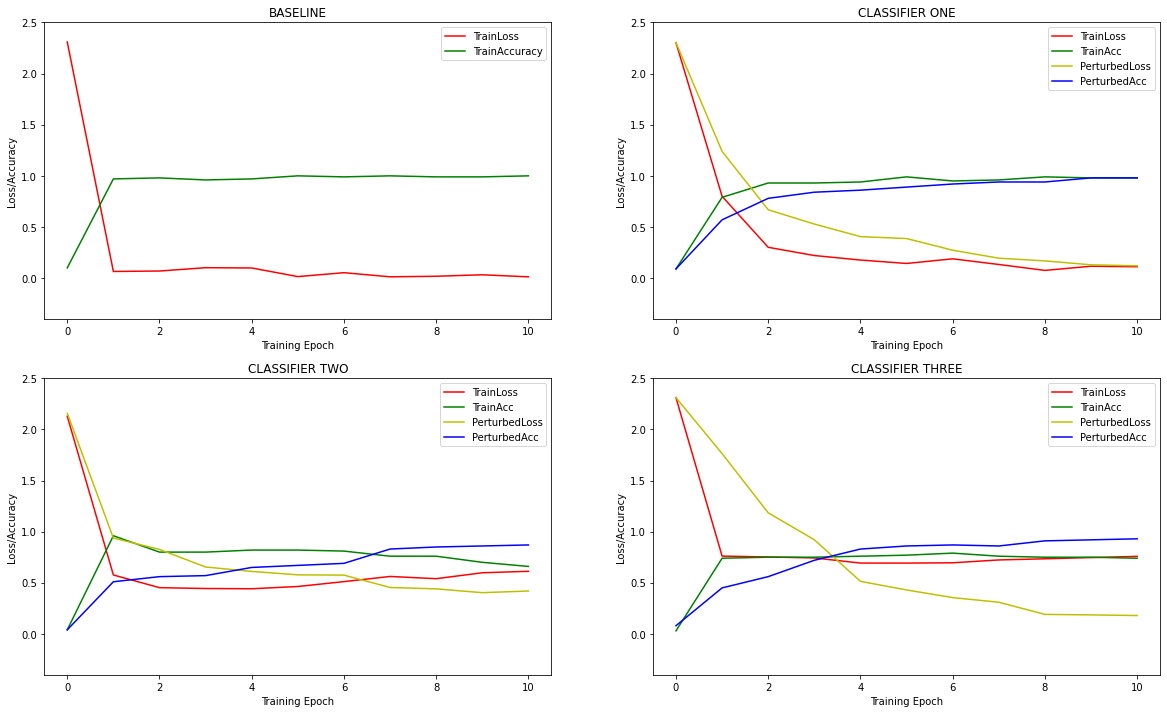

In [139]:
fig, axis = plt.subplots(2, 2)

fig.set_size_inches(20, 12)

# BASELINE
baseline_loss = [2.3095, 0.0648, 0.0692, 0.1016, 0.0989, 0.0146, 0.0528, 0.0125, 0.0179, 0.0324, 0.0123]
baseline_acc = [0.10,0.97,0.98,0.96,0.97,1.00,0.99,1.00,0.99,0.99,1.00]

axis[0,0].plot(range(11), baseline_loss, '-r', label='TrainLoss')
axis[0,0].plot(range(11), baseline_acc, '-g', label='TrainAccuracy') 
axis[0,0].legend(loc='upper right')
axis[0,0].set_title("BASELINE")

# CLASSIFIER ONE
one_loss = [2.3026,0.7997,0.3011,0.2207,0.1765,0.1431,0.1884,0.1331,0.0752,0.1160,0.1109]
one_acc = [0.09,0.79,0.93,0.93,0.94,0.99,0.95,0.96,0.99,0.98,0.98]
one_pertloss = [2.3026,1.2389,0.6683,0.5286,0.4057,0.3866,0.2729,0.1946,0.1683,0.1300,0.1200]
one_pertacc = [0.09,0.57,0.78,0.84,0.86,0.89,0.92,0.94,0.94,0.98,0.98]

axis[0,1].plot(range(11), one_loss, '-r', label='TrainLoss') 
axis[0,1].plot(range(11), one_acc, '-g', label='TrainAcc')
axis[0,1].plot(range(11), one_pertloss, '-y', label='PerturbedLoss') 
axis[0,1].plot(range(11), one_pertacc, '-b', label='PerturbedAcc')
axis[0,1].legend(loc='upper right')
axis[0,1].set_title("CLASSIFIER ONE")

# CLASSIFIER TWO
two_loss = [2.1286,0.5765,0.4522,0.4440,0.4416,0.4637,0.5113,0.5619,0.5400,0.5979,0.6123]
two_acc = [0.04,0.96,0.80,0.80,0.82,0.82,0.81,0.76,0.76,0.70,0.66]
two_pertloss = [2.1578,0.93712,0.82653,0.6543,0.6110,0.5776,0.5749,0.4540,0.4405,0.4033,0.4194]
two_pertacc = [0.04,0.51,0.56,0.57,0.65,0.67,0.69,0.83,0.85,0.86,0.87]

axis[1,0].plot(range(11), two_loss, '-r', label='TrainLoss') 
axis[1,0].plot(range(11), two_acc, '-g', label='TrainAcc')
axis[1,0].plot(range(11), two_pertloss, '-y', label='PerturbedLoss') 
axis[1,0].plot(range(11), two_pertacc, '-b', label='PerturbedAcc')
axis[1,0].legend(loc='upper right')
axis[1,0].set_title("CLASSIFIER TWO")

# CLASSIFIER THREE
three_loss = [2.3105,0.7608,0.7526,0.7430,0.6929,0.6927,0.6955,0.7234,0.7346,0.7467,0.7583]
three_acc = [0.03,0.74,0.75,0.75,0.76,0.77,0.79,0.76,0.75,0.75,0.74]
three_pertloss = [2.3105,1.7630,1.1842,0.9207,0.5140,0.4298,0.3550,0.3099,0.1907,0.1861,0.1795]
three_pertacc = [0.08,0.45,0.56,0.72,0.83,0.86,0.87,0.86,0.91,0.92,0.93]

axis[1,1].plot(range(11), three_loss, '-r', label='TrainLoss') 
axis[1,1].plot(range(11), three_acc, '-g', label='TrainAcc')
axis[1,1].plot(range(11), three_pertloss, '-y', label='PerturbedLoss') 
axis[1,1].plot(range(11), three_pertacc, '-b', label='PerturbedAcc')
axis[1,1].legend(loc='upper right')
axis[1,1].set_title("CLASSIFIER THREE")


for i in range(2):
    for j in range(2):
        axis[i,j].set_ylim([-0.4, 2.5])
        axis[i,j].set_xlabel("Training Epoch")
        axis[i,j].set_ylabel("Loss/Accuracy")

plt.show()
fig.savefig("output/graphs/TrainingLossAccuracy.png")

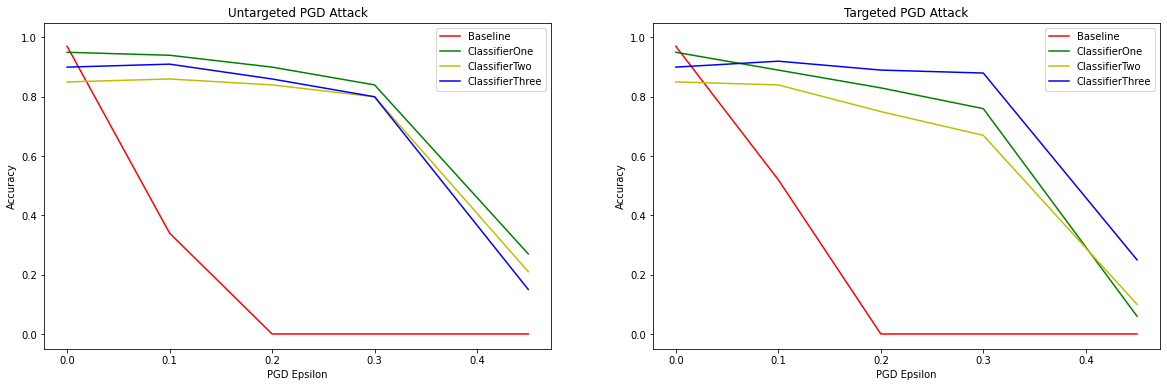

In [138]:
fig, axis = plt.subplots(1, 2)

fig.set_size_inches(20, 6)

baseline_untarget = [0.97,0.34,0.00,0.00,0.00]
one_untarget = [0.95, 0.94, 0.90, 0.84, 0.27]
two_untarget = [0.85,0.86,0.84,0.80,0.21]
three_untarget = [0.9,0.91,0.86,0.80,0.15]

baseline_target = [0.97,0.52, 0.00, 0.00, 0.00]
one_target = [0.95,0.89, 0.83, 0.76, 0.06]
two_target = [0.85,0.84,0.75,0.67,0.10]
three_target = [0.9,0.92,0.89,0.88,0.25]

eps = [0,0.1,0.2,0.3,0.45]

axis[1].plot(eps, baseline_target, '-r', label='Baseline') 
axis[1].plot(eps, one_target, '-g', label='ClassifierOne')
axis[1].plot(eps, two_target, '-y', label='ClassifierTwo') 
axis[1].plot(eps, three_target, '-b', label='ClassifierThree')
axis[1].legend(loc='upper right')
axis[1].set_title("Targeted PGD Attack")

axis[0].plot(eps, baseline_untarget, '-r', label='Baseline') 
axis[0].plot(eps, one_untarget, '-g', label='ClassifierOne')
axis[0].plot(eps, two_untarget, '-y', label='ClassifierTwo') 
axis[0].plot(eps, three_untarget, '-b', label='ClassifierThree')
axis[0].legend(loc='upper right')
axis[0].set_title("Untargeted PGD Attack")



for i in range(2):
    axis[i].set_ylim([-0.05, 1.05])
    axis[i].set_xlabel("PGD Epsilon")
    axis[i].set_ylabel("Accuracy")

plt.show()
fig.savefig("output/graphs/TestingAccuracy.png")